In [1]:
import pandas as pd
import numpy as np

In [38]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GlobalAttention
from torch_geometric.nn import global_mean_pool
import networkx as nx

In [22]:
train_pos = pd.read_csv('train-positive.txt', header=None)
train_neg = pd.read_csv('train-negative.txt', header=None)
test_pos = pd.read_csv('test-positive.txt', header=None)
test_neg = pd.read_csv('test-negative.txt', header=None)

In [23]:
train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T

In [24]:
df = test_neg.append(test_pos).append(train_pos).append(train_neg).reset_index(drop=True)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
df.columns = ['bitter', 'seq']
df

,bitter,seq
0,Negative,AA
1,Negative,IKP
2,Negative,ILP
3,Negative,PFFDPQIP
4,Negative,IPQEVLP
...,...,...
635,Negative,NPPHQIYP
636,Negative,AIYK
637,Negative,ENGLPVHLDQSIFRRP
638,Negative,AMKPW


In [25]:
df = df.sample(frac=1)

In [26]:
df = df.sample(frac=1)
labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).values
seq = df.seq.values

In [27]:
descriptors = list(set([j for i in seq for j in i]))
enc = OneHotEncoder()
X = np.array(descriptors).reshape((-1, 1))
enc_arrays = enc.fit(X)

In [28]:
def create_graph_data(str, label):
    n = len(str)
    edge_index_up = [[i, i+1] for i in range(n-1)]
    edge_index_down = [[i+1, i] for i in range(n-1)]
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = enc.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float) 
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

In [29]:
data_list = []

In [30]:
for i in range(len(labels)):
    d = create_graph_data(seq[i], labels[i])

    data_list.append(d)

In [31]:
train_data, test_data = train_test_split(data_list, test_size=0.1)

In [32]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle = True)

In [33]:
d

Data(x=[2, 20], edge_index=[2, 2], y=1)

In [34]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[224, 20], edge_index=[2, 384], y=[32], batch=[224], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[188, 20], edge_index=[2, 312], y=[32], batch=[188], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[161, 20], edge_index=[2, 258], y=[32], batch=[161], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[171, 20], edge_index=[2, 278], y=[32], batch=[171], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[143, 20], edge_index=[2, 222], y=[32], batch=[143], ptr=[33])

Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[149, 20], edge_index=[2, 234], y=[32], batch=[149], ptr=[33])

Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[153, 20], edge_index=[2, 242], y=[32], batch=[153], ptr=[33])

Step 8:
Number of graphs in the current batch: 32
DataBatch(x=[181, 20], edge_index=[2, 298], y=[32], batch=[181], ptr

In [35]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        self.hidden_channels = hidden_channels
        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        #print(x.size())
        
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x
    
model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [36]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    

    for epoch in range(1, 20):
        
        for data in train_loader:  # Iterate in batches over the training dataset.
            out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
            loss = criterion(out, data.y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train()


Epoch: 001, Train Acc: 0.7882, Test Acc: 0.7812
Epoch: 002, Train Acc: 0.7656, Test Acc: 0.7500
Epoch: 003, Train Acc: 0.8524, Test Acc: 0.8281
Epoch: 004, Train Acc: 0.8819, Test Acc: 0.8438
Epoch: 005, Train Acc: 0.8767, Test Acc: 0.8438
Epoch: 006, Train Acc: 0.8420, Test Acc: 0.8125
Epoch: 007, Train Acc: 0.8941, Test Acc: 0.8281
Epoch: 008, Train Acc: 0.9062, Test Acc: 0.7969
Epoch: 009, Train Acc: 0.8906, Test Acc: 0.8750
Epoch: 010, Train Acc: 0.9115, Test Acc: 0.8594
Epoch: 011, Train Acc: 0.9132, Test Acc: 0.8281
Epoch: 012, Train Acc: 0.9184, Test Acc: 0.8281
Epoch: 013, Train Acc: 0.8958, Test Acc: 0.8594
Epoch: 014, Train Acc: 0.9184, Test Acc: 0.8125
Epoch: 015, Train Acc: 0.9253, Test Acc: 0.8281
Epoch: 016, Train Acc: 0.9358, Test Acc: 0.8125
Epoch: 017, Train Acc: 0.9323, Test Acc: 0.8281
Epoch: 018, Train Acc: 0.9375, Test Acc: 0.8438
Epoch: 019, Train Acc: 0.9323, Test Acc: 0.8281


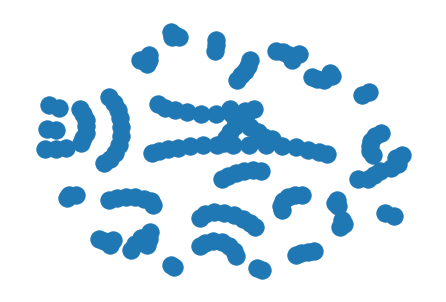

In [40]:
g = to_networkx(data, to_undirected=True)
nx.draw(g)

In [41]:
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

In [42]:
data.batch

tensor([ 0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
         4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,
         7,  7,  8,  8,  9,  9,  9,  9, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 15, 15,
        15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17,
        17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 20, 20, 21, 21,
        21, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 25, 25,
        26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        28, 28, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31])

In [43]:
data.num_graphs

32

In [44]:
data.num_nodes

159

In [45]:
data.x.shape

torch.Size([159, 20])

In [46]:
data.edge_index.shape

torch.Size([2, 254])

In [47]:
data.y.shape

torch.Size([32])

In [48]:
conv1 = GCNConv(20, 64)

In [49]:
x = conv1(data.x,data.edge_index)

In [70]:
x.shape

torch.Size([154, 64])

In [71]:
att = GlobalAttention(x, data.edge_index)

In [85]:
att.gate_nn.shape

torch.Size([154, 64])

In [89]:
global_mean_pool(att.gate_nn, data.batch).shape

torch.Size([32, 64])

In [61]:
out.shape

torch.Size([32, 2])

In [62]:
lab.shape

torch.Size([32])

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

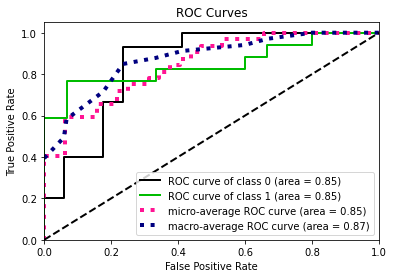

In [63]:
skplt.metrics.plot_roc(lab, out.detach().numpy())

In [102]:
out

tensor([[ 2.2462, -2.4537],
        [ 7.6034, -8.5027],
        [ 2.9989, -3.2956],
        [ 2.7886, -3.0479],
        [-1.7437,  2.1872],
        [-1.2796,  1.6758],
        [-0.3250,  0.5287],
        [ 2.6257, -2.8674],
        [ 1.8732, -1.9760],
        [-1.7553,  2.2046],
        [-1.5066,  1.9576],
        [ 4.6090, -5.1747],
        [ 0.3856, -0.2727],
        [-1.1945,  1.6134],
        [ 1.5878, -1.6243],
        [-5.1605,  6.1338],
        [-1.1872,  1.5404],
        [-0.2895,  0.5211],
        [-8.4703, 10.1710],
        [-1.0354,  1.3945],
        [-1.6628,  2.1594],
        [ 2.0241, -2.1371],
        [-1.2829,  1.6408],
        [ 4.7655, -5.3197],
        [-1.1997,  1.5662],
        [ 4.1134, -4.6084],
        [-0.4020,  0.6807],
        [ 0.3095, -0.1938],
        [-1.1689,  1.5585],
        [ 1.2908, -1.3006],
        [ 1.9227, -2.0764],
        [-2.0251,  2.5803]], grad_fn=<AddmmBackward0>)